In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress import progress_bar
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import skew
from scipy.signal import find_peaks
import matplotlib.patches as mpatches
from collections import Counter
from google.colab import data_table

In [8]:
#Uniform color map for the labels (to display graphs below)
color_map = {0:(0.38,0.38,0.38), 1:(0.94,0.80,0), 2:(0.94,0.63,0), 3:(0.76,0,0)}
cmap = LinearSegmentedColormap.from_list("", [color_map[0], color_map[1], color_map[2], color_map[3]])

In [18]:
#Download the training data
!gdown -O mafat_wifi_challenge_training_set_v1.csv https://drive.google.com/uc?id=121CbFZbU6kAWNjmjZF232DsiGF2-BoYy
train_path = '/content/mafat_wifi_challenge_training_set_v1.csv'

Downloading...
From: https://drive.google.com/uc?id=121CbFZbU6kAWNjmjZF232DsiGF2-BoYy
To: /content/mafat_wifi_challenge_training_set_v1.csv
100% 74.7M/74.7M [00:00<00:00, 125MB/s]


##**Functions:**

In [130]:
"""
Lists of features to extract from each vector
"""

DEFAULT_TRUE_LIST = [True] * 8
DEFAULT_TRUE_DICT = {
    'RSSI': [True, False, False, False, True, True, True, True],
    'RSSI_diffs': [True, True, True, False, True, True, True, True],
    'RSSI_diffs_abs': [False, False, True, True, True, False, True, True],
    'RSSI_median_dist': [True, False, True, True, True, False, True, True]
}

In [179]:
def extract_list_feats(list_name: str, data, features_name: list, base=None):
    """
    Extract Features from vector.
    :param list_name: Vector to extract features from.
    :param data: Dataset to extract features from.
    :param features_name: Feature list to add new feature names to.
    :param base: Disable the use of features.
    :return: Data with features, updated feature name list.
    """

    if base is None:
        base = DEFAULT_TRUE_LIST

    data[f'max_{list_name}'] = data[list_name].apply(np.max)
    if base[0]:
        features_name += [f'max_{list_name}']

    data[f'min_{list_name}'] = data[list_name].apply(np.min)
    if base[1]:
        features_name += [f'min_{list_name}']

    data[f'mean_{list_name}'] = data[list_name].apply(np.mean)
    if base[2]:
        features_name += [f'mean_{list_name}']

    data[f'median_{list_name}'] = data[list_name].apply(np.median)
    if base[3]:
        features_name += [f'median_{list_name}']

    data[f'std_{list_name}'] = data[list_name].apply(np.std)
    if base[4]:
        features_name += [f'std_{list_name}']

    data[f'skew_{list_name}'] = data[list_name].apply(skew)
    if base[5]:
        features_name += [f'skew_{list_name}']

    data[f'max_sub_min_{list_name}'] = data[list_name].apply(lambda x: np.max(x) - np.min(x))
    if base[6]:
        features_name += [f'max_sub_min_{list_name}']
 
    data[f'fft_{list_name}'] = data[list_name].apply(np.fft.fft)
    if base[7]:
        features_name += [f'fft_{list_name}']

    return data, features_name

In [132]:
def extract_features(data, bases=None):
    """
    Extract features from data.
    :param data: Dataset of time windows.
    :param bases: Dictionary with values of bool lists of size 7 and keys of the names of the vectors to extract
    features from
    :return: new dataset with extracted features, training feature name list
    """
    if bases is None:
        bases = DEFAULT_TRUE_DICT

    features_name = []
    data['RSSI_diffs'] = data.RSSI.apply(lambda x: x[1:] - x[:-1])
    data['RSSI_diffs_abs'] = data.RSSI.apply(lambda x: abs(x[1:] - x[:-1]))
    data['RSSI_median_dist'] = data.RSSI.apply(lambda x: abs(x - np.median(x)))

    data, features_name = extract_list_feats('RSSI', data, features_name, base=bases['RSSI'])
    data, features_name = extract_list_feats('RSSI_diffs', data, features_name, base=bases['RSSI_diffs'])
    data, features_name = extract_list_feats('RSSI_diffs_abs', data, features_name, base=bases['RSSI_diffs_abs'])
    data, features_name = extract_list_feats('RSSI_median_dist', data, features_name, base=bases['RSSI_median_dist'])

    data['max_count_same_value_RSSI'] = data.RSSI.apply(lambda x: np.max(np.unique(x, return_counts=True)[1]))
    features_name += ['max_count_same_value_RSSI']

    data['RSSI_peaks'] = data.RSSI.apply(lambda x: len(find_peaks(x)[0]))
    features_name += ['RSSI_peaks']

    data['RSSI_diffs_peaks'] = data.RSSI_diffs.apply(lambda x: len(find_peaks(x)[0]))
    features_name += ['RSSI_diffs_peaks']

    data['peak_ratio_diffs_RSSI'] = data.apply(
        lambda x: x['RSSI_diffs_peaks'] / x['RSSI_peaks'] if x['RSSI_peaks'] > 0 else 0, axis=1)
    features_name += ['peak_ratio_diffs_RSSI']

    data['RSSI_values_count'] = data.RSSI.apply(lambda x: len(np.unique(x)))
    features_name += ['RSSI_values_count']

    return data, features_name

In [133]:
def window(full_signal: np.ndarray, size: int = 360, stride: int = 360):
    """
    Take a long vector of signals and creates time windows of size "size" and stride of size "stride"
    :param full_signal: the signal to make time windows from
    :param size: size of each time window
    :param stride: stride (step size)
    :return: time windows of the signal
    """
    return np.lib.stride_tricks.sliding_window_view(full_signal, size)[0::stride]

In [134]:
def make_data(data, window_size: int = 360, stride: int = 360):
    """
    Make data for training a model: making windows, adding metadata information to the time windows dataframe, removing
    windows with change in tfisoot
    :param data: the data.
    :param window_size: size of each time window
    :param stride: time window stride (step size)
    :return: time windows dataframe, labels dataframe
    """

    # Check that the size of the Device_Id data is bigger than the window size
    for dev_id in list(set(data.Device_ID)):
        sub_dev = data.loc[data.Device_ID == dev_id]
        if len(sub_dev) < window_size:
           data = data[data.Device_ID != dev_id]

    X, y = data.drop(columns=['Num_People']), data['Num_People']
    
    X['Num_People'] = y
    multi_vals = X.groupby(['Device_ID']).apply(lambda x: x.nunique() == 1).all()
    single_vals = list(multi_vals[multi_vals].index)
    multi_vals = list(multi_vals[~multi_vals].index)
    windows_df = X.groupby(['Device_ID']).RSSI.apply(
        lambda x: window(x.values, window_size, stride)).explode().to_frame().reset_index()
    for col in (multi_vals + single_vals):
        windows_df[col] = X.groupby(['Device_ID'])[col].apply(
            lambda x: window(x.values, window_size, stride)).explode().reset_index(drop=True).values
    for col in single_vals:
        windows_df[col] = windows_df[col].apply(lambda x: x[0])
    
    df = windows_df
    df['change'] = df.Num_People.apply(lambda x: (len(np.unique(x)) > 1))
    dfx = df[~df['change']]
    df = dfx.copy()
    df.Num_People = df.Num_People.apply(lambda x: x[0])
    df.drop(columns='change', inplace=True)
    return df.drop(columns='Num_People'), df.Num_People

In [135]:
def plot_distribution(X,y, feature: str):
    """
    Plotting the distribution of a feature.
    :param X: X of the dataset.
    :param y: y of the dataset (number_people).
    :param feature: Feature Name.
    :return: None.
    """

    data = X.copy()
    data['Num_People'] = y
    size_option_num_people = len(list(set(y)))
    

    fig,ax = plt.subplots(1,size_option_num_people +1,figsize=(30,10))
    fig.suptitle(f'{feature} distributions')
    min_f = 0
    max_f = 0
    for num in range(size_option_num_people):
        max_temp = np.max(data[data.Num_People == num][feature].value_counts().values / len(data[data.Num_People == num]))
        if max_temp> max_f:
              max_f =max_temp 

    if feature == 'peak_ratio_diffs_RSSI':
        for num in range(size_option_num_people):
            ax[0].bar(np.arange(len(data[data.Num_People == num][feature].value_counts().keys())),
                      data[data.Num_People == num][feature].value_counts().values / len(data), alpha=0.5,  color=color_map[num])
            ax[0].set_title('All number of people')
            ax[0].set_ylim([min_f, max_f])
            ax[num+1].bar(np.arange(len(data[data.Num_People == num][feature].value_counts().keys())),
                    data[data.Num_People == num][feature].value_counts().values / len(data[data.Num_People == num]),
                    label=f'{num}', alpha=0.5, color=color_map[num])
            ax[num+1].set_title(f'Number of people - {num}')
            ax[num+1].set_ylim([min_f, max_f])
        plt.xticks(np.arange(len(data[feature].value_counts().keys())),
                   labels=[round(x, 2) for x in data[feature].value_counts().keys()], rotation=45)
            
    else:
        if np.issubdtype(data[feature].dtype, np.integer) or data[feature].nunique() < 50:
            try:
                d = np.diff(np.unique(data[feature])).min()
                left_min = data[feature].min() - (d / 2)
                right_max = data[feature].max() + (d / 2)
                bins = np.arange(left_min, right_max + d, d)
            except ValueError:
                bins = 30
            except MemoryError:
                bins = 30  
        else:
            bins = 30
        
        
        for num in range(size_option_num_people):
            ax[0].hist(data[data.Num_People == num][feature],
                  bins=bins, range=[min_f, max_f], alpha = 0.5, label=f'{num}',  color=color_map[num],
                  weights=np.ones(len(data[data.Num_People == num])) / len(data[data.Num_People == num]))
            ax[0].legend(title='Number of people in the room')
            ax[0].set_title('All number of people')
            ax[0].set_ylim([min_f, max_f])
            ax[num+1].hist(data[data.Num_People == num][feature],
                 bins=bins, range=[min_f, max_f], alpha=0.5, label=f'{num}',
                 weights=np.ones(len(data[data.Num_People == num])) / len(data[data.Num_People == num]),
                 color=color_map[num])
            ax[num+1].set_title(f'Number of people - {num}')
            ax[num+1].set_ylim([min_f, max_f])
    plt.show()

In [136]:
def read_data():
    """
    Read train data, remove nan data.
    return: DataFrame.
    """
    data = pd.read_csv(train_path)
    data.dropna(subset = ["Num_People"], inplace=True)
    return data

In [137]:
def plot_rssi_spect(rssi_data, rssi_labels, room):
    """
    Plot RSSI data per sample time for every receiver. 
    :param rssi_data: rssi values
    :param rssi_labels: label of the rssi
    :param room: number room.
    :return: None.
    """
    # Plot spectrogram of csi amplitude and phase, side by side with labels (number of people in the room)
    fig, ax = plt.subplots(ncols=2,figsize=(20, 10))
    fig.suptitle(f'RSSI per time sample (0.5 seconds) - Room {room}', fontsize=18, y=1.03)

    im0 = ax[0].imshow(rssi_data, aspect='auto')  
    im2 = ax[1].imshow(rssi_labels.reshape(rssi_labels.shape[0],1),extent=[0,1000,np.max(rssi_data.index.values)*2,np.min(rssi_data.index.values)], cmap=cmap)


    x_label_list =  rssi_data.columns.tolist()
    ax[0].set_xticks(np.arange(0,len(x_label_list)))
    ax[0].set_xticklabels(x_label_list)

    ax[0].set_title(f'RSSI', fontsize=14)
    ax[0].set_xlabel('Receivers', fontsize=14)
    ax[0].set_ylabel('Time Sample (0.5 seconds)', fontsize=14)
    ax[0].figure.colorbar(im0, ax=ax[0])
    

    ax[1].set_title(f'Number of people in the room', fontsize=14)
    ax[1].get_xaxis().set_ticks([])
    ax[1].set_ylabel('Time Sample (0.5 seconds)', fontsize=14)
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()


    l_colors= [list(color_map[0]),list(color_map[1]),list(color_map[2]),list(color_map[3])]
    [(l_colors[i]).append(1.0) for i in range(len(l_colors))]
    tup_colors = [tuple(l_colors[0]), tuple(l_colors[1]), tuple(l_colors[2]),tuple(l_colors[3])]
    patches = [ mpatches.Patch(color=tup_colors[i], label="{l}".format(l=i) ) for i in range(len(tup_colors)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.tight_layout()
    plt.show()

#**EDA:**

##**Load Data**

In [180]:
data = read_data()

In [181]:
data.head()

,Time,Room_Num,Device_ID,RSSI_Left,RSSI_Right,Num_People
0,0.0,3,92178,-42,-51,2.0
1,0.5,3,92178,-42,-51,2.0
2,1.0,3,92178,-42,-51,2.0
3,1.5,3,92178,-42,-51,2.0
4,2.0,3,92178,-42,-51,2.0


In [182]:
#List of devices in each room
data_table.DataTable(data.astype(str).groupby('Room_Num')[['Device_ID']].agg(lambda x: ', '.join(x.unique())), include_index=True, num_rows_per_page=10)

,Device_ID
Room_Num,
1,"28530, 83989, 410, 51635, 71296, 55268, 91999,..."
2,"28218, 1544, 74706, 57857, 17094, 59970, 90789..."
3,"92178, 87913, 57022, 1429, 51237, 64752, 81928..."
4,"78424, 45144, 93763, 68231, 34071, 33118, 22033"
5,"74744, 91654, 71472, 45121, 74591, 19010, 6036..."
6,"79721, 23449, 78664, 287, 85581, 19890, 32460,..."


##**Visualize data**

Select the signal values for display ​​(RSSI_Left/ RSSI_Right/ the minimum value ​​between the signals/ The maximum value ​​between the signals/ average of signals)-

In [183]:
#@title 
RSSI_value_selection = "Min" #@param ["RSSI_Left","RSSI_Right","Min","Max","Average"]
RSSI = RSSI_value_selection
if RSSI=="RSSI_Left":
    data["RSSI"] = data.RSSI_Left
elif RSSI=="RSSI_Right":
    data["RSSI"] = data.RSSI_Right
elif RSSI=="Min":
    data["RSSI"] = data[['RSSI_Left','RSSI_Right']].min(axis=1).values
elif RSSI=="Max":
    data["RSSI"] = data[['RSSI_Left','RSSI_Right']].max(axis=1).values
else: 
    data["RSSI"] = np.ceil(data[['RSSI_Left','RSSI_Right']].mean(axis=1).values).astype('int')

Select the room number for display-

In [184]:
room = "4" #@param ["1","2","3","4","5","6"]

**Visualization RSSI by the selected rooms**

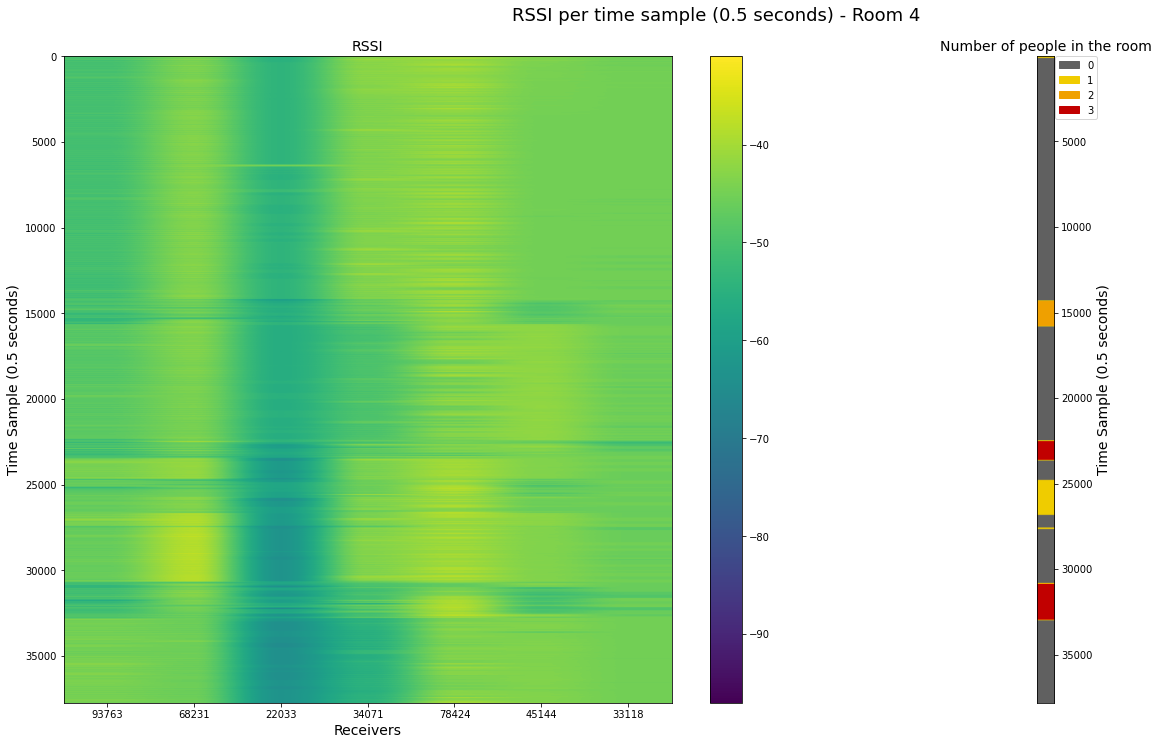

In [185]:
room_val= int(room)
data_for_spec_room = data[data["Room_Num"] == room_val]

rssi_data = pd.DataFrame()
rssi_labels = []
max_time = max([len(data_for_spec_room[data_for_spec_room["Device_ID"] == receiver]) for receiver in list(set(data_for_spec_room['Device_ID']))])
dev_for_timeline = int(data_for_spec_room.iloc[data_for_spec_room.Time.argmax(),:].Device_ID)
sample_time = data_for_spec_room[data_for_spec_room.Device_ID== dev_for_timeline].Time.tolist()
for receiver in list(set(data_for_spec_room['Device_ID'])):
    rssi_receiver = list(data_for_spec_room[data_for_spec_room["Device_ID"] == receiver]['RSSI'])
    label = data_for_spec_room[data_for_spec_room["Device_ID"] == receiver]['Num_People']
    if len(rssi_receiver) < max_time:
        rssi_receiver = rssi_receiver + [0]*(max_time-len(rssi_receiver))
    rssi_data[receiver] = rssi_receiver
    if len(label) == max_time:
        rssi_labels = label
rssi_data['sample_time'] = sample_time
rssi_data.set_index('sample_time', inplace=True)
plot_rssi_spect(rssi_data, np.array(rssi_labels), room_val)

Select the device's id to display.
The ids table appears in the previous section. Enter Device id names separated by single white space-

In [186]:
Enter_Device_ID_for_analysis_without_comma = "79721 23449 78664 287 85581 19890 32460 11488  88733 67900 93834 18366 28851 48756 32980 1747 78997" #@param {type: "string"}
receivers = list(map(int,Enter_Device_ID_for_analysis_without_comma.split( )))

**RSSI visualization by selected Device IDs**

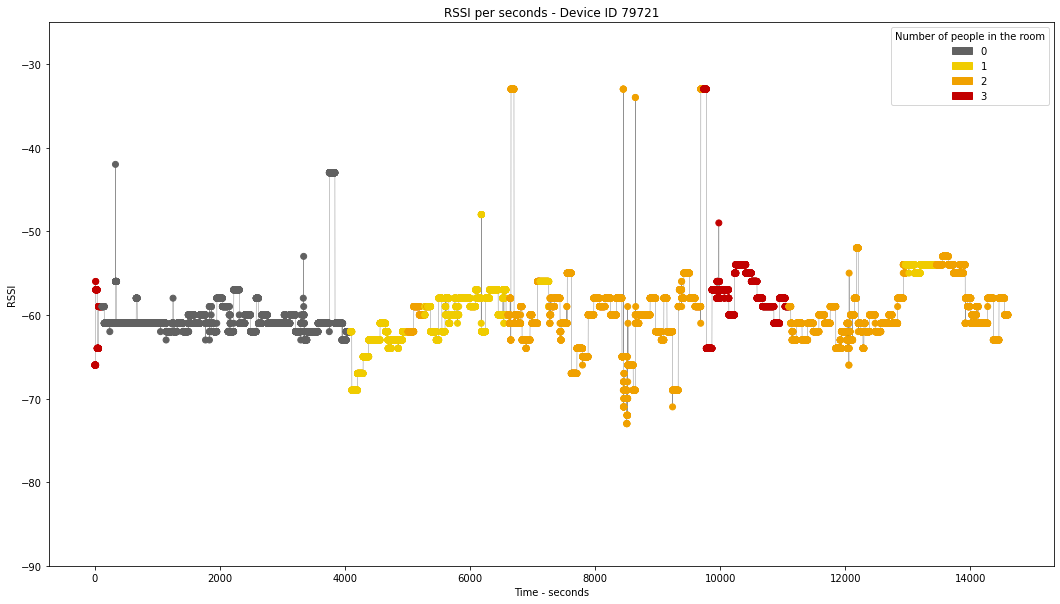

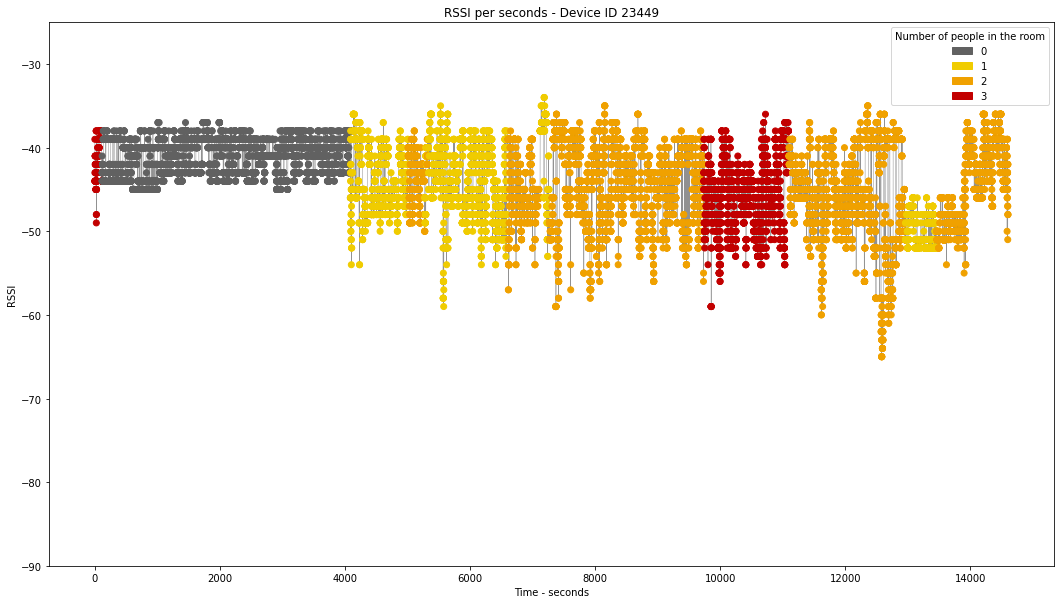

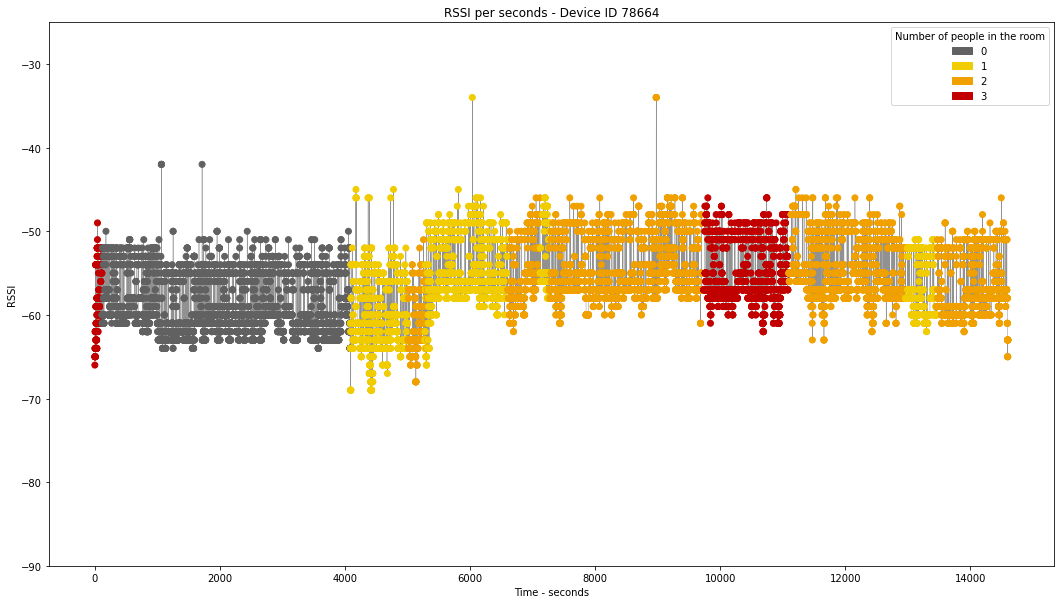

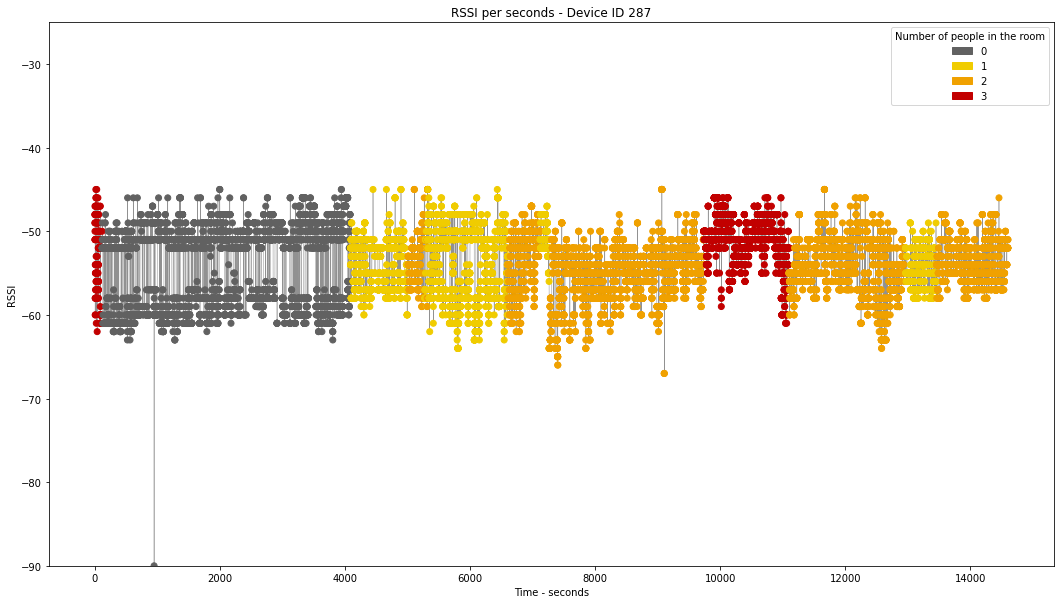

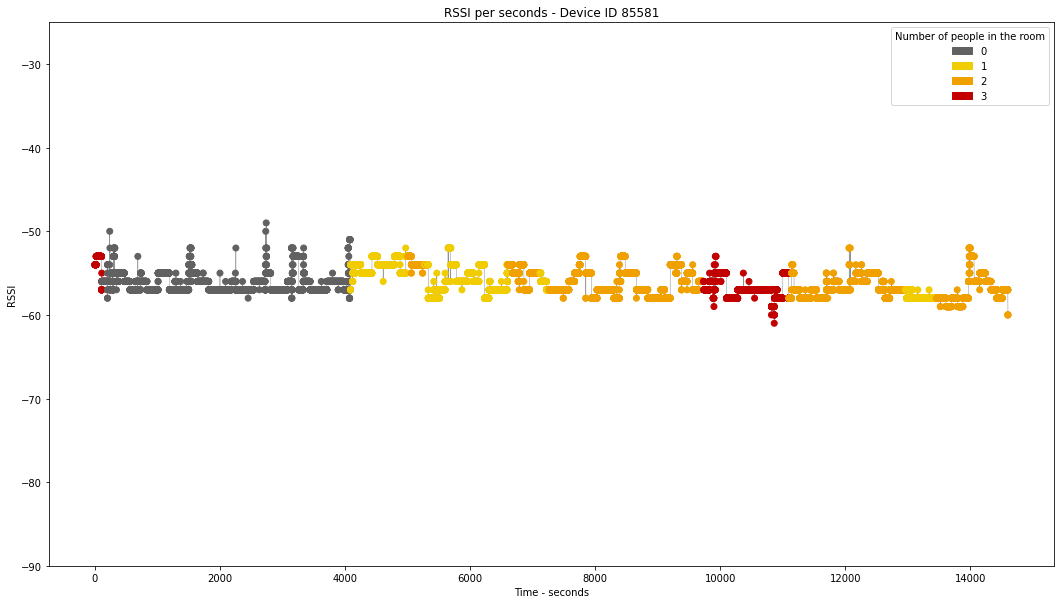

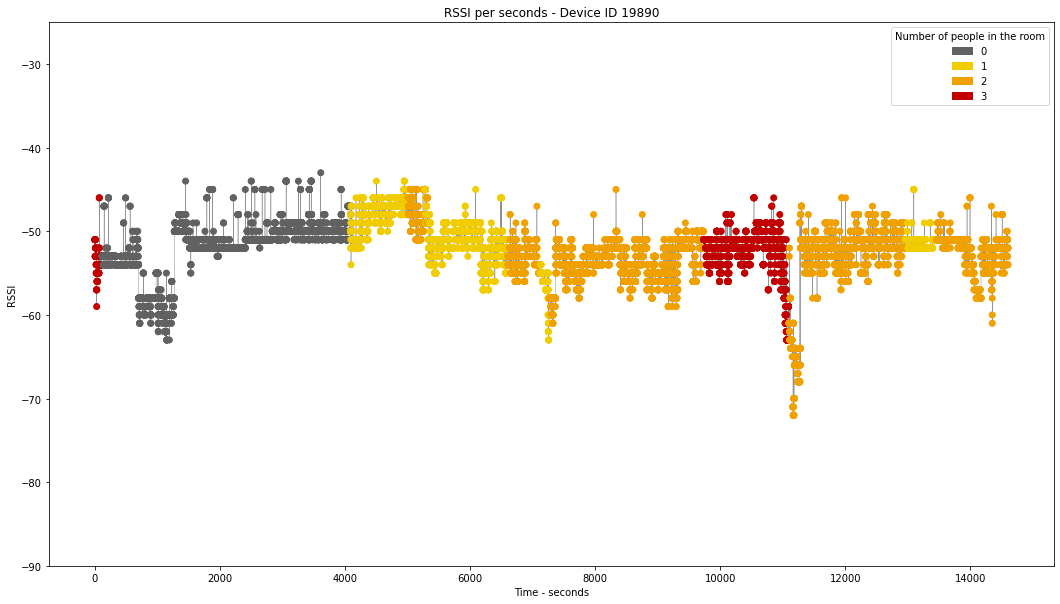

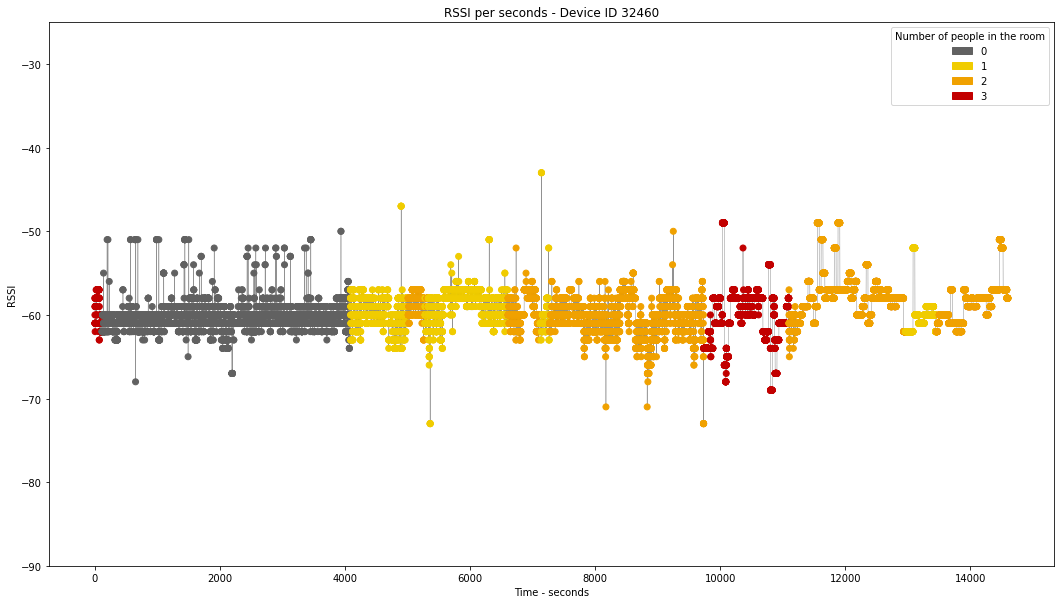

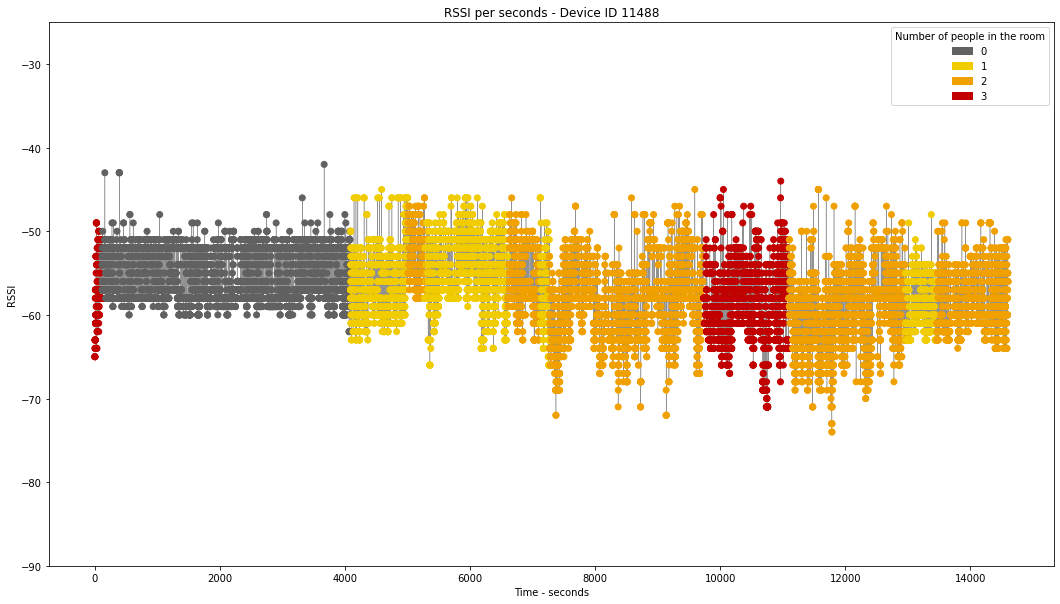

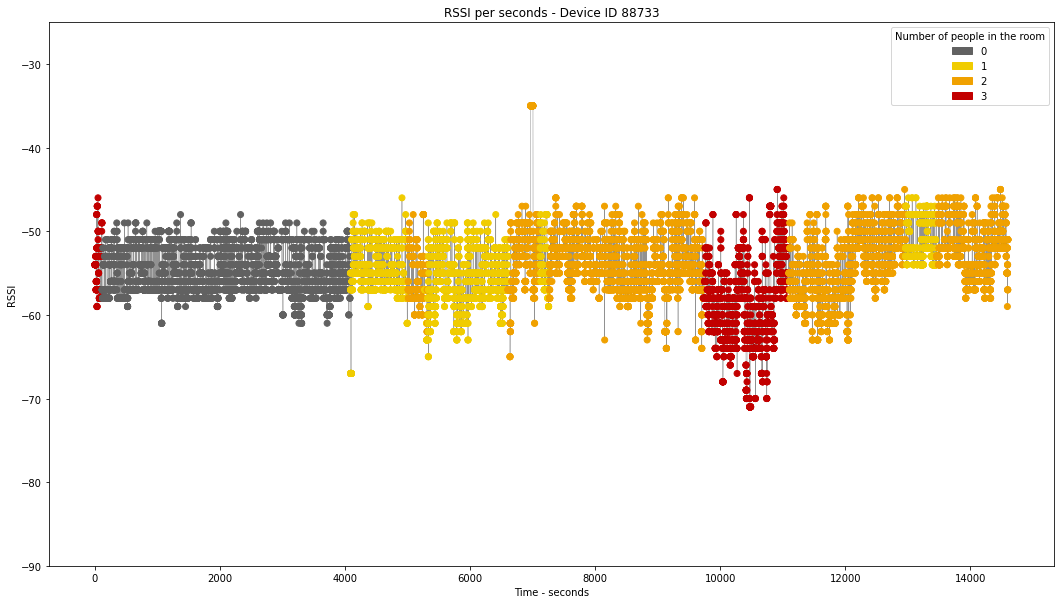

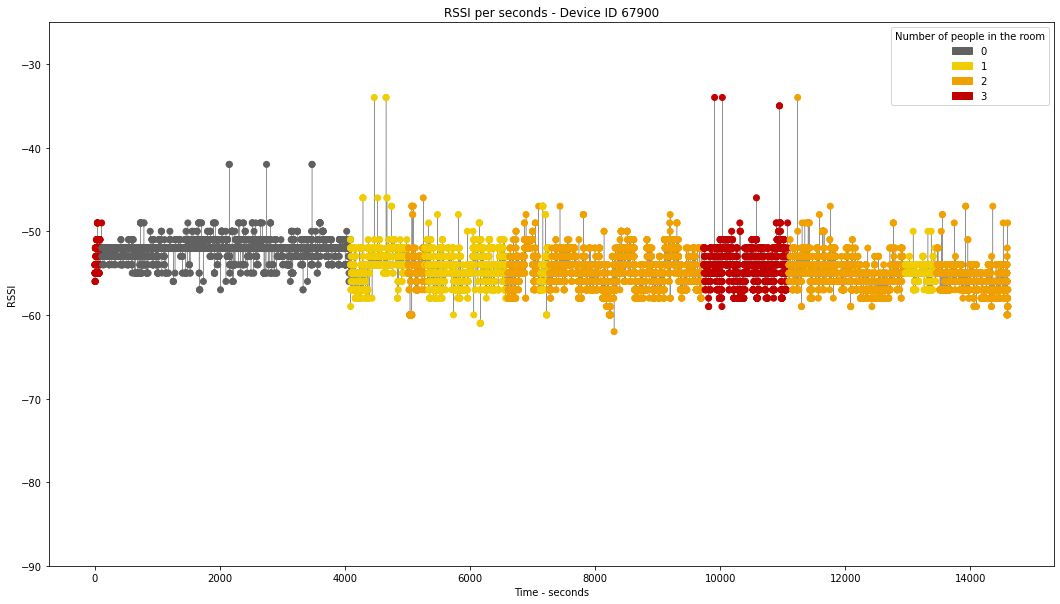

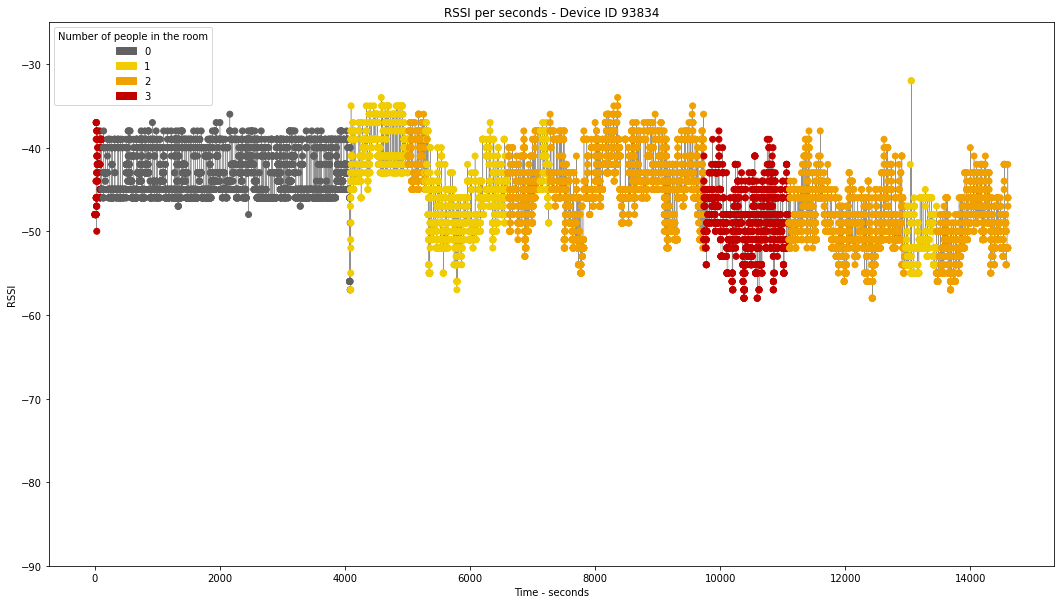

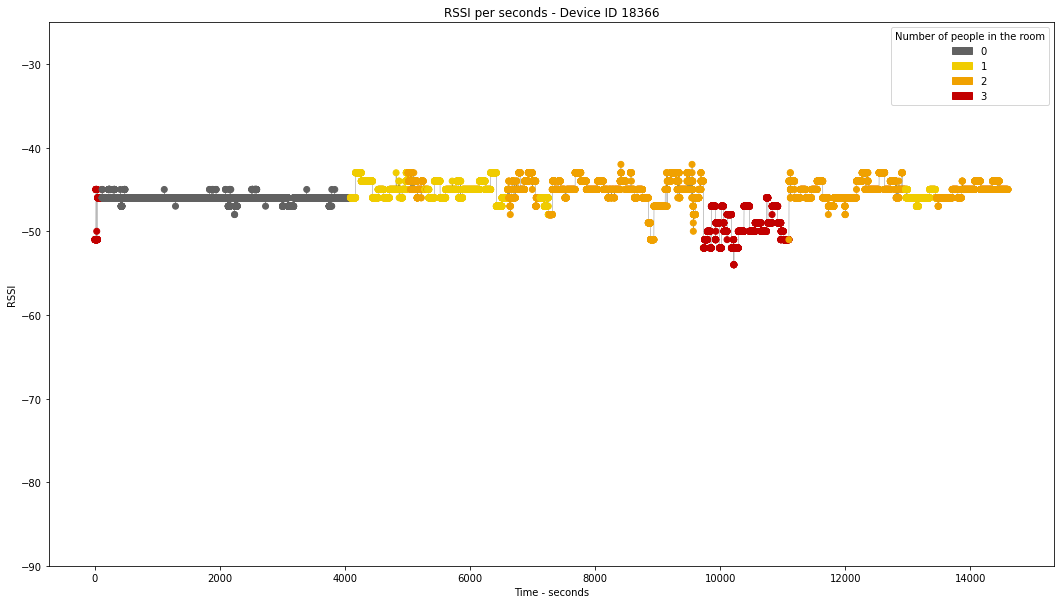

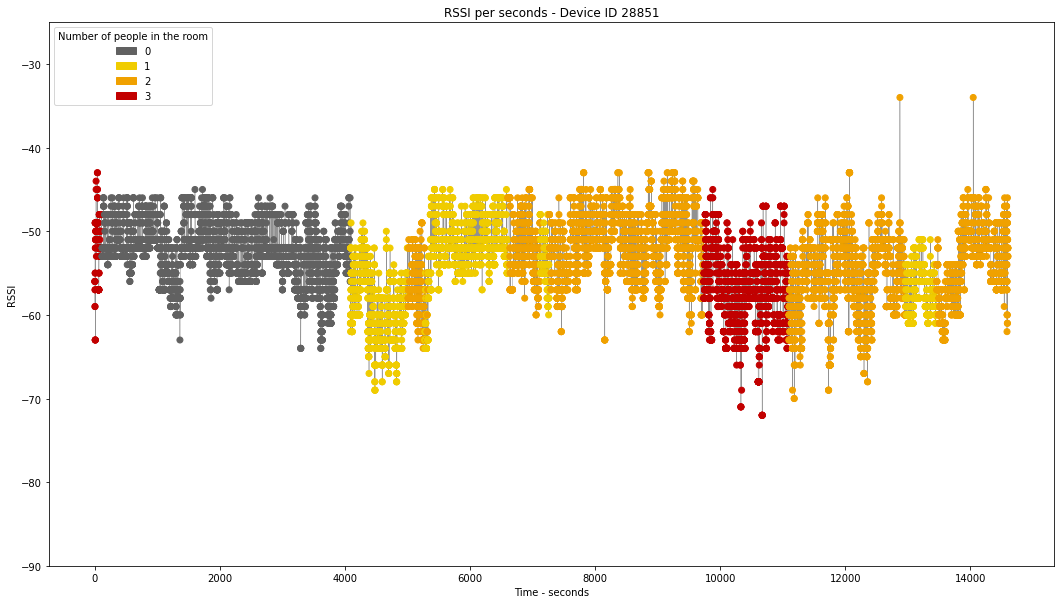

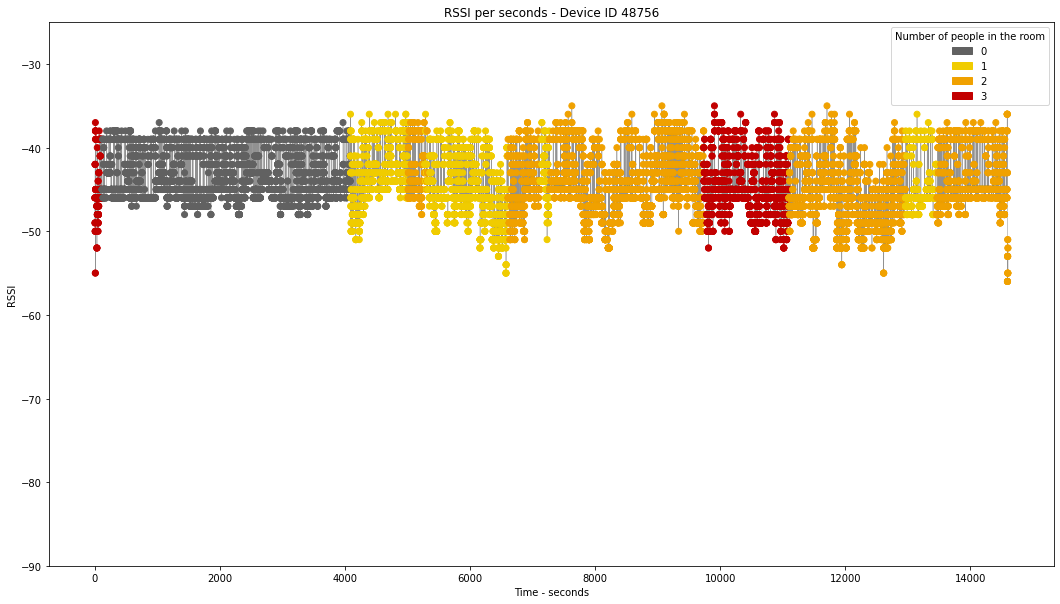

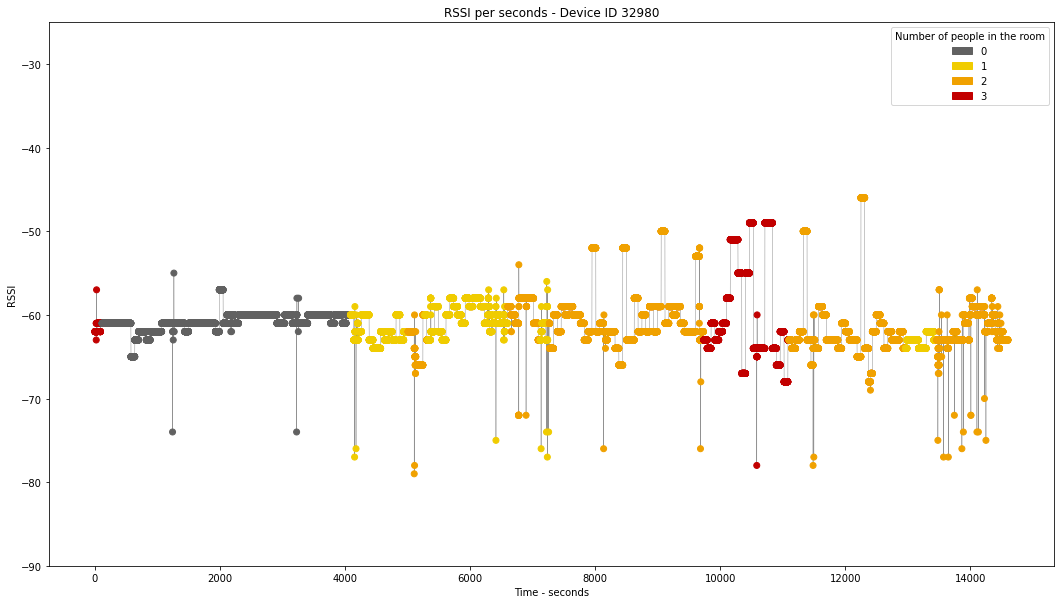

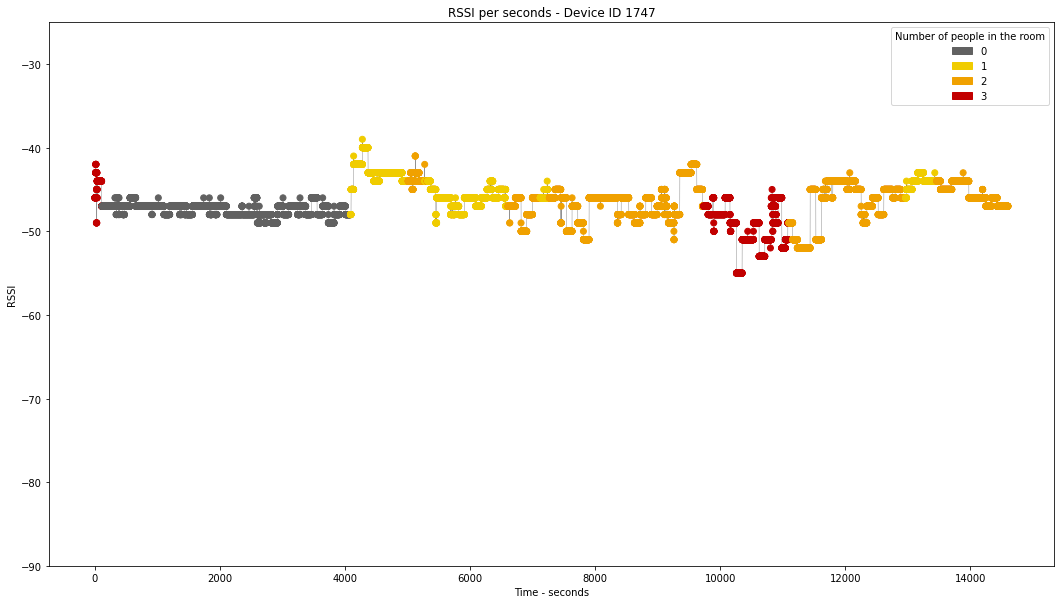

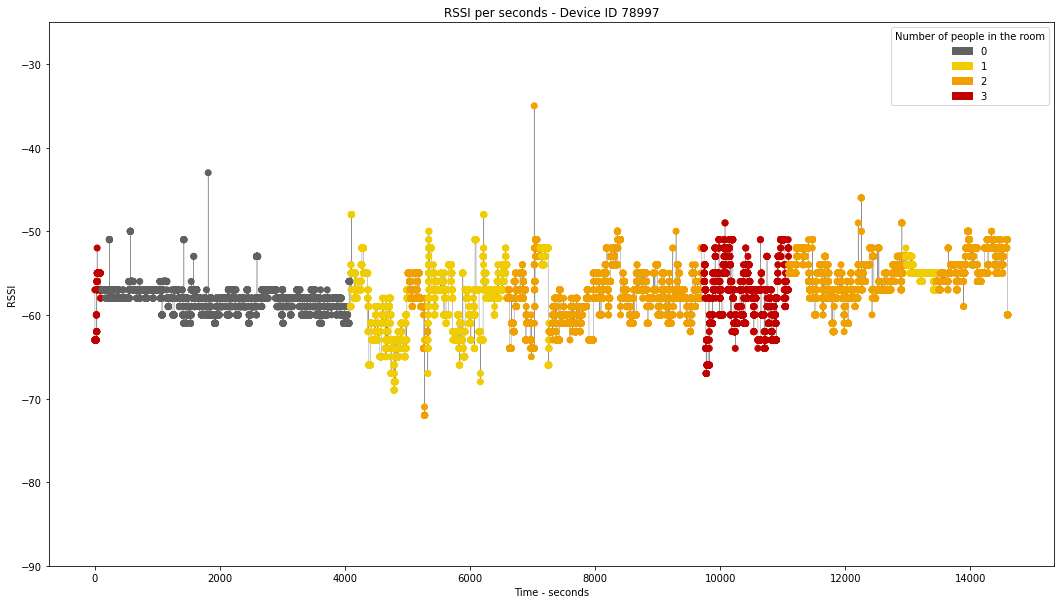

In [187]:
list_patch = []
for var in color_map.keys():
    list_patch.append(mpatches.Patch(color=color_map[var], label=str(var)))
for receiver in receivers:
    receiver_data = data[data["Device_ID"] == receiver]
    time_changes = receiver_data['Time'].tolist()
    label_color = [color_map[i] for i in receiver_data['Num_People']]
    plt.figure(figsize=(18,10))
    plt.plot(time_changes, receiver_data['RSSI'], zorder=1, color=(0.57,0.57,0.57), linewidth=0.5)
    plt.scatter(time_changes, receiver_data['RSSI'], c=label_color, zorder=2)
    plt.title(f'RSSI per seconds - Device ID {receiver}')
    plt.xlabel('Time - seconds')
    plt.ylabel('RSSI')
    plt.legend(handles=list_patch, title='Number of people in the room')
    plt.ylim([-90,-25])
    plt.show()

**Number of people distribution**

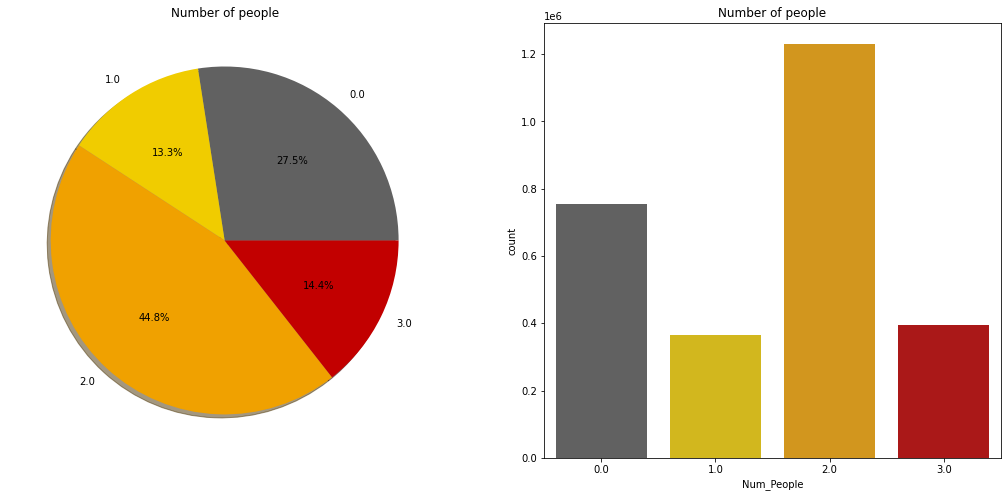

In [188]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Num_People'].value_counts().sort_index().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True, colors=color_map.values())
ax[0].set_title('Number of people')
ax[0].set_ylabel('')
sns.countplot(x = 'Num_People',data=data,ax=ax[1], palette=color_map.values())
ax[1].set_title('Number of people')
plt.show()

## **Time windows**

select window size. 
**Attention- in the test set, window sizes' are set to 360 timestamps**

In [189]:
#@title 
window_size =  360#@param {type:"integer"}

In [190]:
#make data  - split the data to time windows grouped by Device_ID
X, y = make_data(data, window_size=window_size, stride=window_size)

**Number of time windows per Device ID**

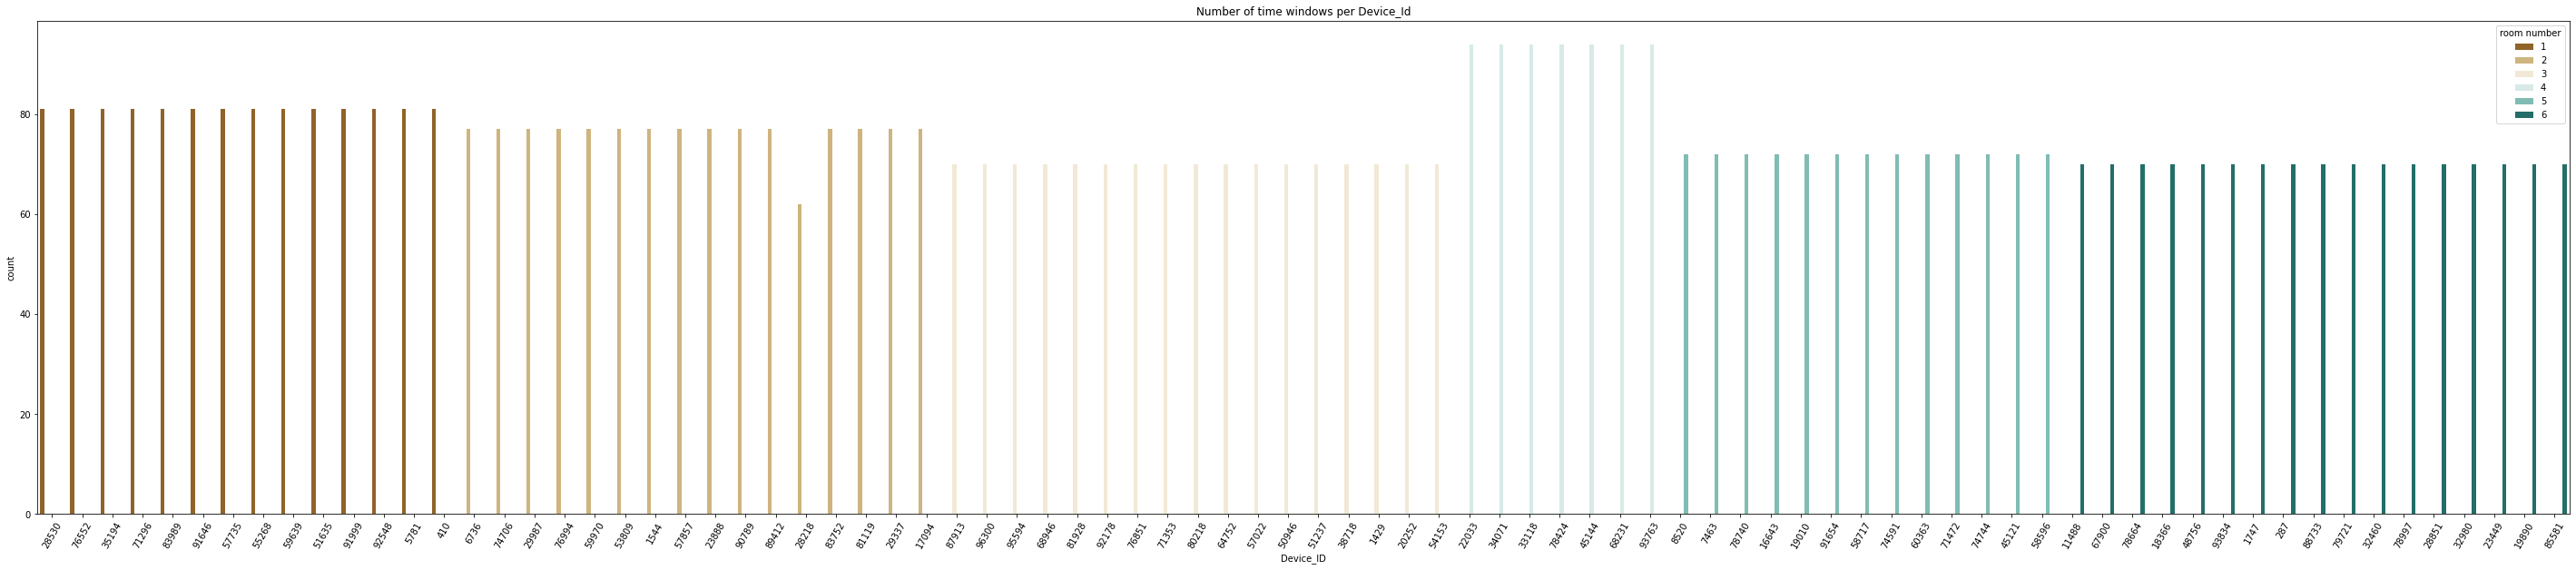

In [191]:
X["Device_ID"] = X["Device_ID"].astype("string")
X = X.sort_values(by=['Room_Num'])
plt.figure(figsize=(50,10))
sns.countplot(x='Device_ID',data=X, hue='Room_Num',palette=sns.color_palette("BrBG"))
plt.xticks(rotation=60)
plt.title('Number of time windows per Device_Id')
plt.legend(loc='upper right', title="room number")
plt.show()

## **Extract features**

This is a suggestion for basic feature engineering. We encourage you to create more advanced features.

In [193]:
X = X.drop(columns=['Room_Num', 'Device_ID'])

In [210]:
data, train_feat = extract_features(X.copy())

In [211]:
print(f'Number of features: {len(train_feat)}')

Number of features: 28


**Feature distribution per number of people in the room**

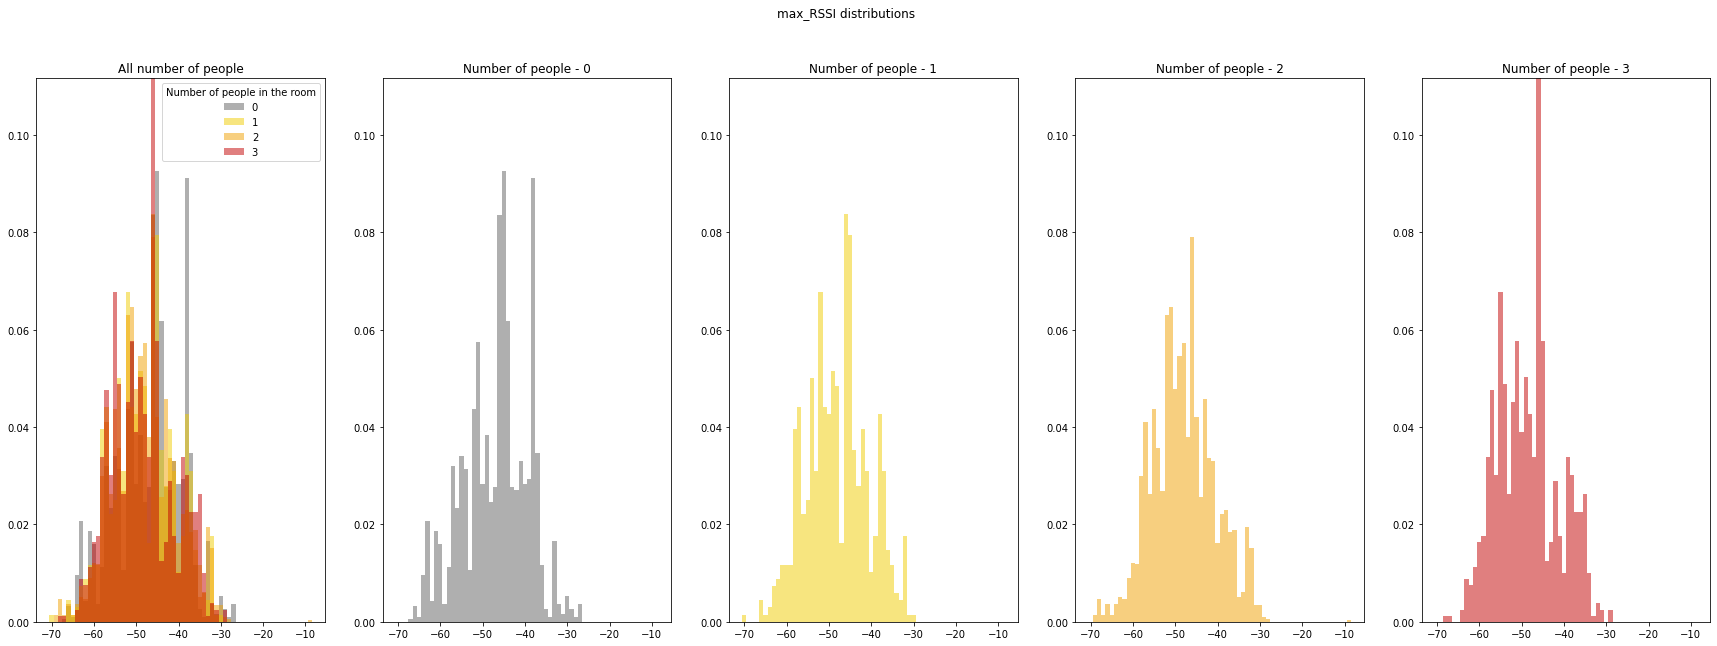

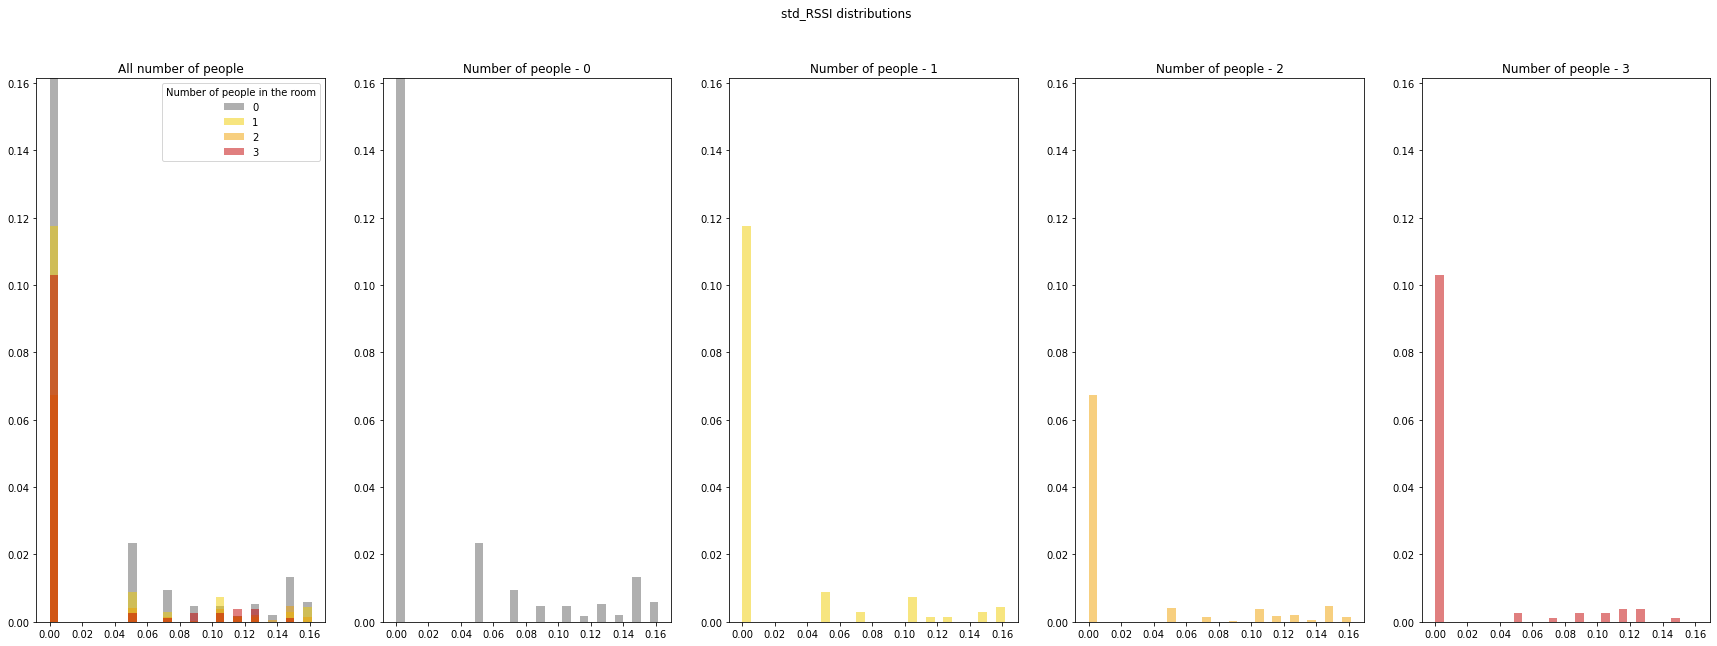

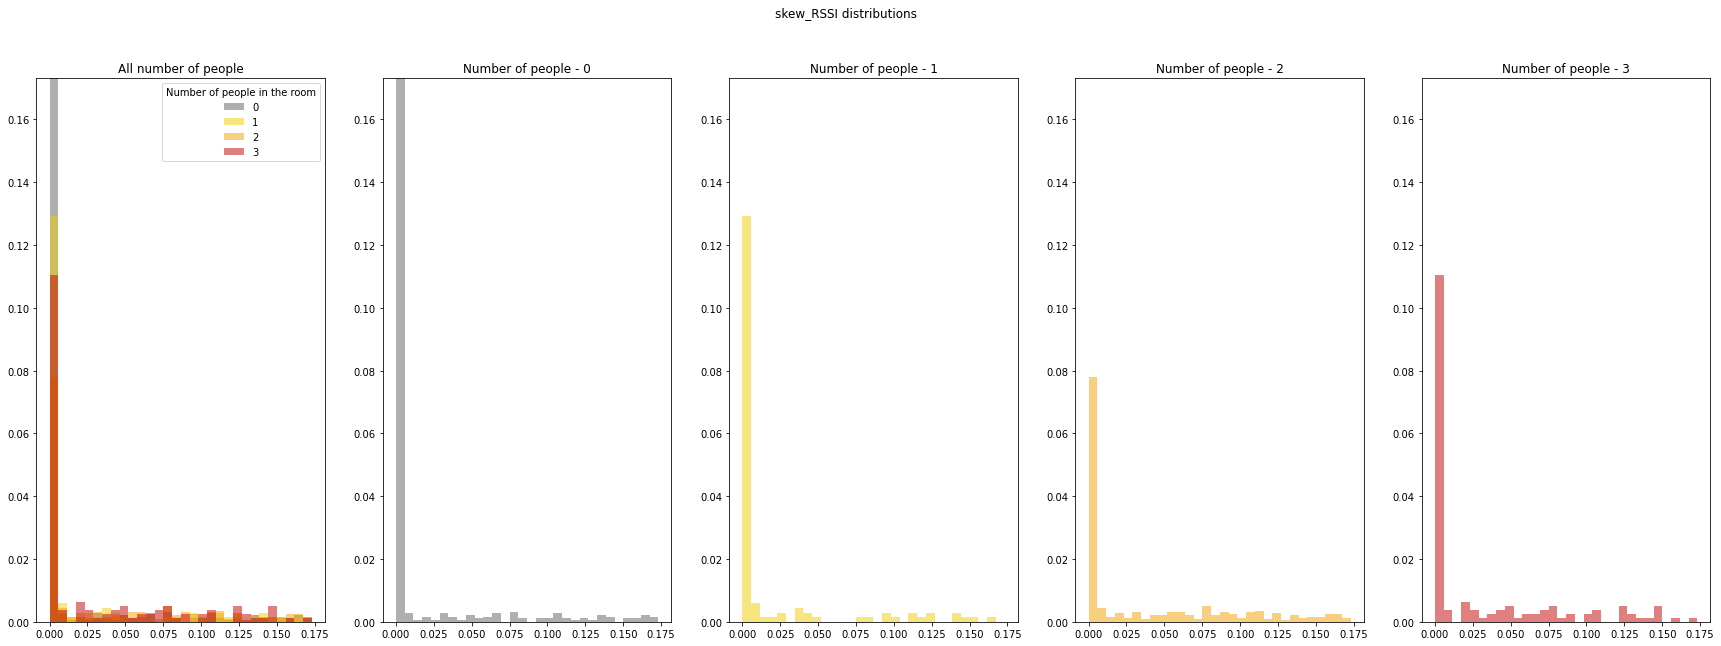

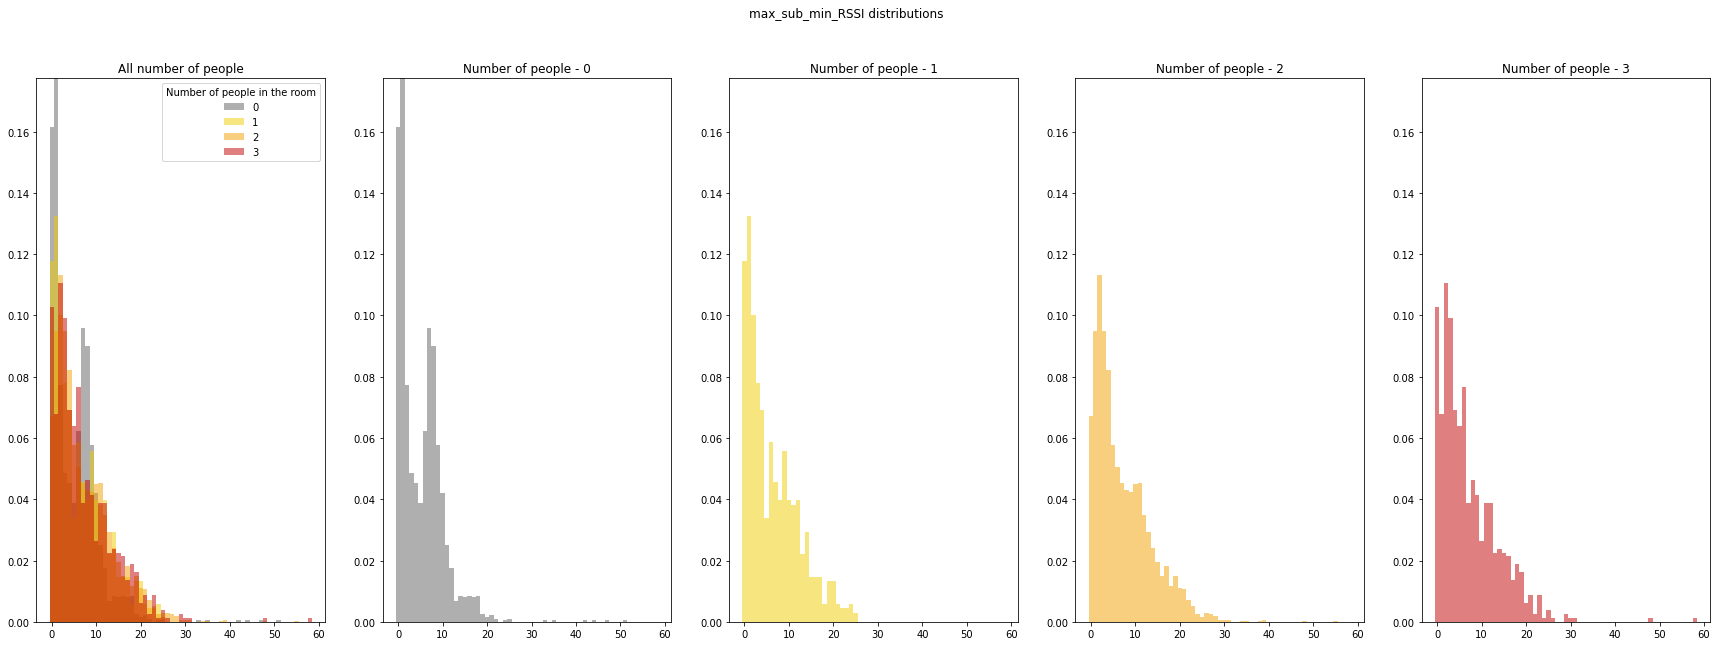

TypeError: ignored

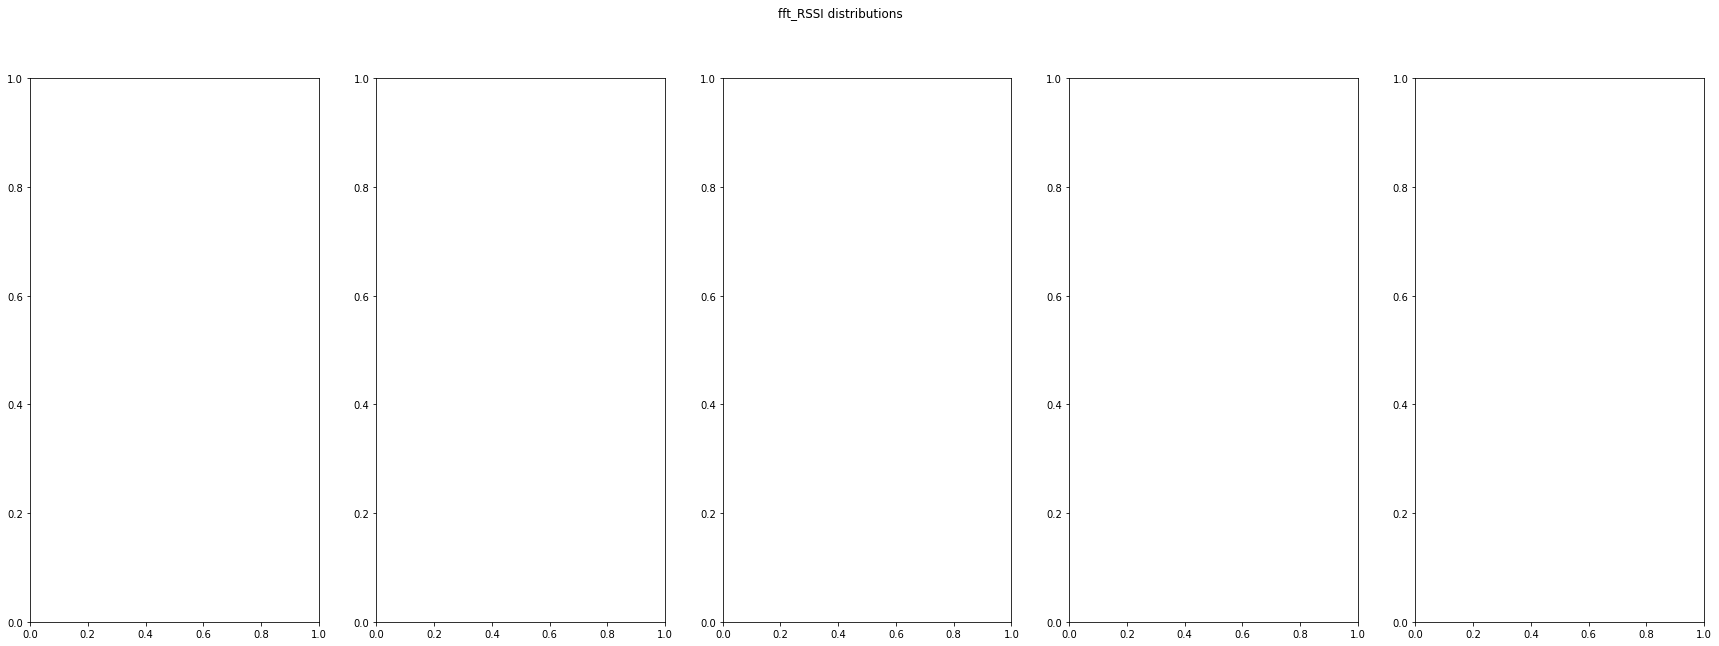

In [105]:
for i, feature in enumerate(progress_bar(train_feat)):
    if feature[0:3] == 'fft_':
        continue
    plot_distribution(data, y, feature=feature)


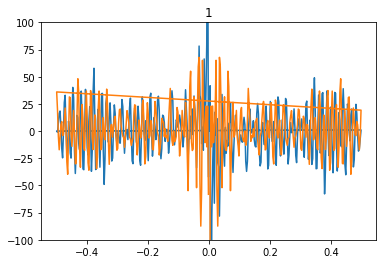

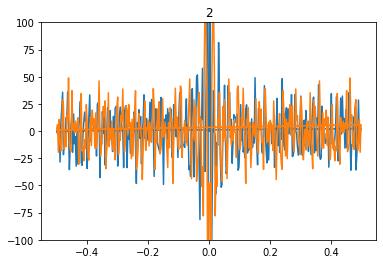

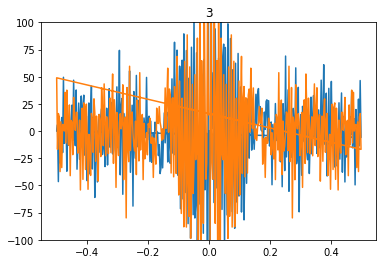

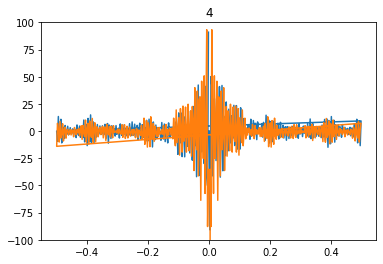

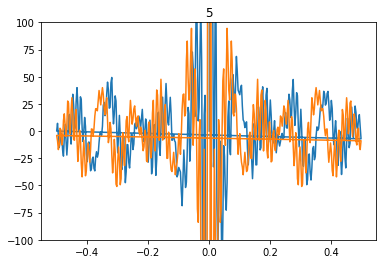

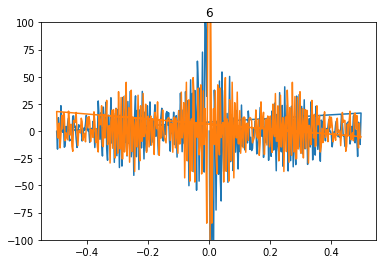

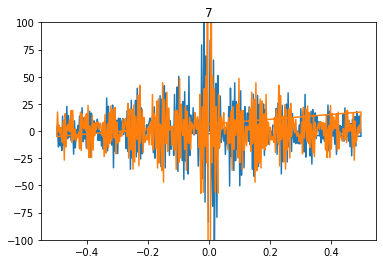

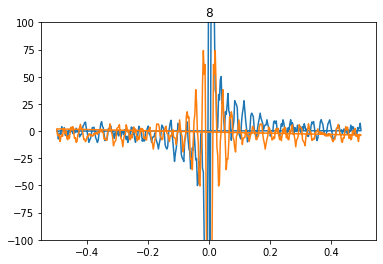

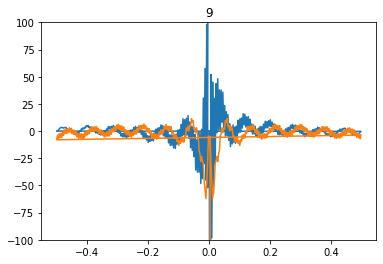

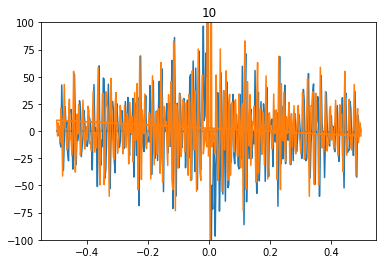

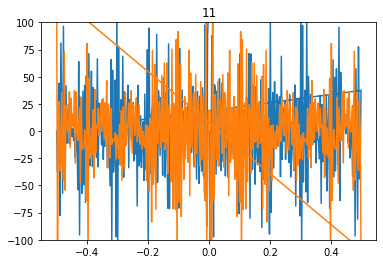

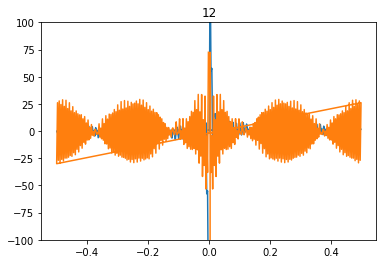

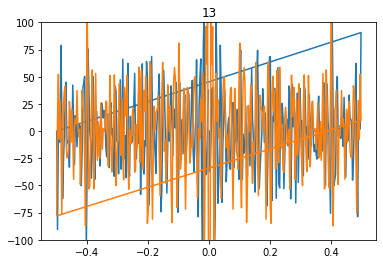

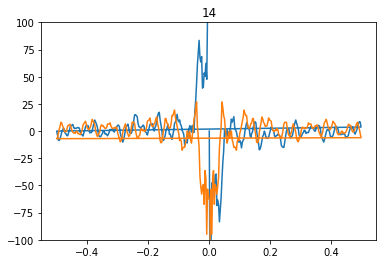

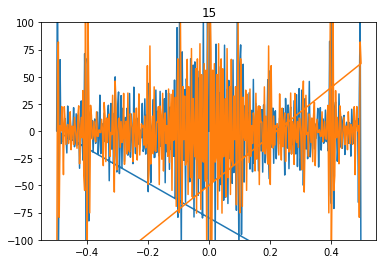

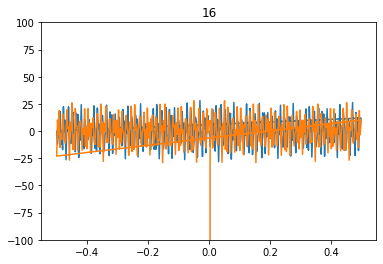

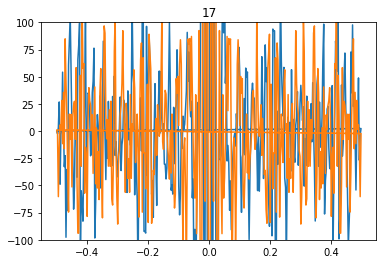

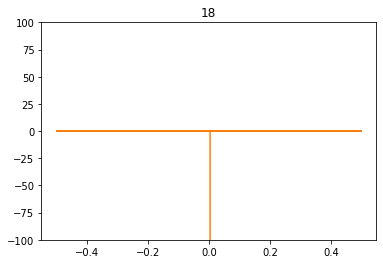

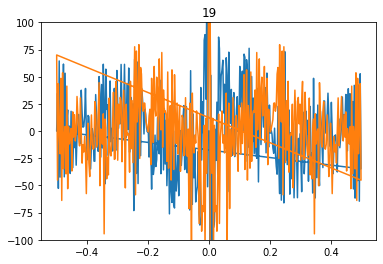

In [214]:
#data = data.reset_index()
for i in  range(1,20):
  plt.figure()
  sp = data.fft_RSSI.to_numpy()[i]
  freq = np.fft.fftfreq((np.arange(0,360)/2).shape[-1])
  plt.plot(freq, sp.imag, freq, sp.real)
  plt.ylim(-100,100)
  plt.title(i)
  #print(data.fft_RSSI.to_numpy()[15 + i])


In [206]:
y.reset_index().loc[range(0,35)]

,index,Num_People
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0
